# Evaluating KSS performance

Question

## 1. Importing necessary libraries 

In [22]:
from typing import TextIO, List, Union, Dict, Tuple
import doctest
from sentiment import *
from random import shuffle
import csv
import sys
import math
import pandas as pd
import matplotlib.pyplot as plt

## 2. Partitioning data into Test and training data

Fisrt we created a function to partition the full dataset into test and training data 

In [7]:
def partition_dataset(file:TextIO, file_name:str, test_size:float) -> Dict:
    """Precondition: test_size > 0.0 and < 1.0 (one decimal)
    Create two datasets sorted randomly from the original. The test_dataset has the size
    requested in test_size, and the trainin_dataset has the remaining size.
    Print a message e.g., "The files: test_data.txt and training_data.txt were created",
    and return a dictionary e.g., {'test': 'test_data.txt', 'training': 'training_data.txt'}
    
    >>> file_names = partition_dataset(open('full.txt', 'r'), 'data', 0.2)
    The files: test_data.txt and training_data.txt were created
    >>> file_names
    {'test': 'test_data.txt', 'training': 'training_data.txt'}
    """
    all_reviews = file.readlines()
    shuffle(all_reviews)
    rating_counts = {}
    test_reviews = []
    training_reviews = []
    for review in all_reviews:
        if review[0] in rating_counts:
            rating_counts[review[0]].append(review)
        else:
            rating_counts[review[0]] = [review]
    #print(rating_counts['4'])
    for rating, reviews in rating_counts.items():
        #print(rating, values)
        length_of_test_data = round(len(reviews) * (test_size))
        test_reviews.extend(reviews[:length_of_test_data])
        training_reviews.extend(reviews[length_of_test_data:])
    test_file_name = "test_" + file_name + ".txt"
    training_file_name = "training_" + file_name + ".txt"

    with open(test_file_name, 'w') as test_file:
        for row in test_reviews:
            test_file.write(row)

    with open(training_file_name, 'w') as training_file:
        for row in training_reviews: 
            training_file.write(row)

    print('The files: '+ test_file_name + ' and ' + training_file_name + ' were created')
    return {'test':test_file_name, 'training':training_file_name}
 

## 3. Training the model


In [8]:
def testing_pss(test_file:TextIO, common_words_file:TextIO ,kss: Dict[str, List[int]], name_datasets) -> Dict:
    """Create a csv dataset with the comparison of the scores given by the kss model and the original ones. Print the message "The file: reviews_comparison.csv was created" and return the dictionary {'file':'reviews_comparison.csv'}
    
    >>> testing_result = testing_pss(open('full.txt', 'r'), kss)
    The file: reviews_comparison.csv was created
    >>> testing_result
    {'file': 'reviews_comparison.csv'}
    """
    common_words_file = common_words_file.read().splitlines()
    review_scores = []
    absolute_errors = []
    test_reviews = test_file.readlines()
    
    #sharpened variables
    kss_sharpened = {}
    absolute_errors_sharpened = []  
    
    ### remove all common words
    # for word, value in kss.items():
    #     if word not in common_words_file:
    #         kss_sharpened[word] = value
    
    ### Remove all words that appears 20 times more
    for word, value in kss.items():
        if not value[1] > 20:
            kss_sharpened[word] = value
    
    ### Remove all neutral words in common words list
    # neutral_words = []
    # for word in common_words_file:
    #     if word_kss(word, kss) != None:
    #         if judge(word_kss(word, kss)) != "neutral":
    #             neutral_words.append(word)
    # for word, value in kss.items():
    #     if word not in neutral_words:
    #         kss_sharpened[word] = value
    
    ### Add more weights to not neutral words
    # for word, values in kss.items():
    #     if word_kss(word, kss) != None:
    #         kss_sharpened[word] = values
    # for word, value in kss_sharpened.items():
    #     if judge(word_kss(word, kss))!="neutral":
    #         kss_sharpened[word] = [(value[0]*1.2),value[1]]
    
    ### Add more weights to not neutral words without neutral words
    # not_neutral_words = []
    # for word in common_words_file:
    #     if word_kss(word, kss) != None:
    #         if judge(word_kss(word, kss)) != "neutral":
    #             not_neutral_words.append(word)
    # for word, value in kss.items():
    #     if word not in not_neutral_words:
    #         kss_sharpened[word] = [value[0]*1.5,value[1]]
            
    ### Portion of occurences in all occurences
    
              
    for review in test_reviews:
        statement = review[1:].strip()
        original_rating = float(review[0])
        
        # original predicted rating
        predicted_rating = statement_pss(review, kss)
        if predicted_rating != None:
            is_close_val = math.isclose(predicted_rating, original_rating, abs_tol=0.05)
            absolute_error = round((abs(float(predicted_rating) - original_rating)), 2)
            absolute_errors.append(absolute_error)
            mean_absolute_error = round(sum(absolute_errors)/len(absolute_errors), 5)
            review_scores.append([statement, round(predicted_rating, 2), round(predicted_rating), original_rating, absolute_error, is_close_val])
        
        # sharpened predicted rating
        predicted_rating_sharpened = statement_pss(review, kss_sharpened)
        if predicted_rating_sharpened != None:
            absolute_error_sharpened = round((abs(float(predicted_rating_sharpened) - original_rating)), 2)
            absolute_errors_sharpened.append(absolute_error_sharpened)
            mean_absolute_error_sharpened = round(sum(absolute_errors_sharpened)/len(absolute_errors_sharpened), 5)
    if predicted_rating_sharpened != None:
        print(name_datasets + " org rate: \t", mean_absolute_error)
        print(name_datasets + " new rate: \t", mean_absolute_error_sharpened)
       
    with open('reviews_'+ name_datasets + '.csv', mode ='w') as comparison_file:
        comparison_writer = csv.writer(comparison_file, delimiter=",", quotechar='"', quoting = csv.QUOTE_MINIMAL)
        comparison_writer.writerow(["Mean Absolute Error(MAE): " + str(mean_absolute_error) ])
        comparison_writer.writerow(["-","-","-","-","-"])
        comparison_writer.writerow(["Review", "PSS Score", "Predicted Rating", "Original Rating", "Absolute Error", "Evaluation Result"])
        for row in review_scores:
            comparison_writer.writerow(row)

    print('The file:' + 'reviews_'+ name_datasets + '.csv' + ' was created')
    return {'Mean Absolute Error(MAE): ', mean_absolute_error}


In [9]:
def execute_test(datasets: Dict[str, str], partition_size):
    for name in datasets:
        with open(datasets[name], 'r') as file:
            file_names = partition_dataset(file, name, partition_size)
        with open(file_names['training'], 'r') as training_file:
                kss = extract_kss(training_file)  
        with open(file_names['test'], 'r') as test:
            with open("most_common_english_words.txt") as common_words_file:
                testing_result = testing_pss(test, common_words_file, kss, name)

## 4. Testing the model


In [12]:
if __name__ == "__main__":
    
    #Create a dictionary containing diferent datasets, in order to compare accuracies among each other.
    datasets =  {
        "small"     : "small.txt",
        "medium"    : "medium.txt",
        "full"      : "full.txt"
    }        
    
    
    execute_test(datasets, 0.2)

    # Pick a dataset  
    # dataset = 'tiny.txt'
    # dataset = 'small.txt'
    #dataset = 'medium.txt'
    dataset = 'full.txt'

     # Test if the training and test datasets were created
    name_datasets = 'data'
     
    with open(dataset, 'r') as file:
        file_names = partition_dataset(file, name_datasets, 0.2)

 

    # Training the model with the training dataset created
    with open(file_names['training'], 'r') as training_file:
        kss = extract_kss(training_file)  


    # Testing the results with the test dataset created
    with open(file_names['test'], 'r') as test:
        with open("most_common_english_words.txt") as common_words_file:
            testing_result = testing_pss(test, common_words_file, kss, name_datasets)
   
    # Use test mode

    #doctest.testmod()

The files: test_small.txt and training_small.txt were created
small org rate: 	 0.98833
small new rate: 	 0.98833
The file:reviews_small.csv was created
The files: test_medium.txt and training_medium.txt were created
medium org rate: 	 1.06163
medium new rate: 	 1.05041
The file:reviews_medium.csv was created
The files: test_full.txt and training_full.txt were created
full org rate: 	 1.00452
full new rate: 	 0.95001
The file:reviews_full.csv was created
The files: test_data.txt and training_data.txt were created
data org rate: 	 1.00233
data new rate: 	 0.9638
The file:reviews_data.csv was created


## 5. Analysing the results

In [20]:
evaluated_reviews = pd.read_csv('reviews_full.csv', header=2)
evaluated_reviews.head()

,Review,PSS Score,Predicted Rating,Original Rating,Absolute Error,Evaluation Result
0,"The tonal shifts are jolting , and though Wen ...",2.37,2,2.0,0.37,False
1,"Um , no. .",1.00,1,2.0,1.00,False
2,As happily glib and vicious as its characters .,1.71,2,2.0,0.29,False
3,Wobbly Senegalese updating of '' Carmen '' whi...,2.47,2,2.0,0.47,False
4,Acting can not be acted .,2.11,2,2.0,0.11,False


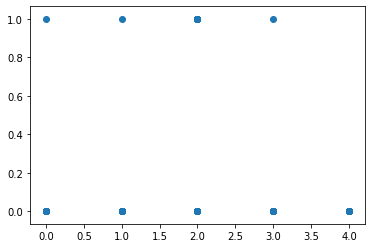

In [23]:
plt.scatter(evaluated_reviews['Original Rating'],evaluated_reviews['Evaluation Result'])